fatal: destination path 'stocknet-dataset' already exists and is not an empty directory.
Date,Open,High,Low,Close,Adj Close,Volume
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
2012-09-11,95.015717,95.728569,93.785713,94.370003,85.265068,125995800
2012-09-12,95.264282,95.699997,93.714287,95.684288,86.452538,178058300
2012-09-13,96.767143,97.928574,96.395714,97.568573,88.155037,149590000
2012-09-14,98.565712,99.568573,98.269997,98.754288,89.226341,150118500
2012-09-17,99.907143,99.971428,99.230003,99.968575,90.323479,99507800
2012-09-18,99.982857,100.332855,99.488571,100.272858,90.598404,93375800
2012-09-19,100.037140,100.570000,99.938568,100.300003,90.622932,81718700
2012-09-20,99.87999

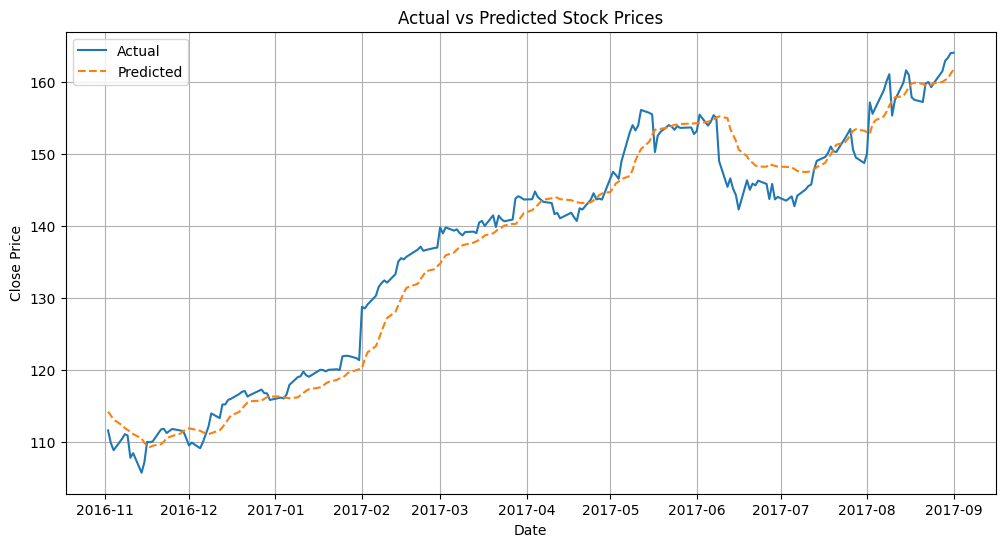

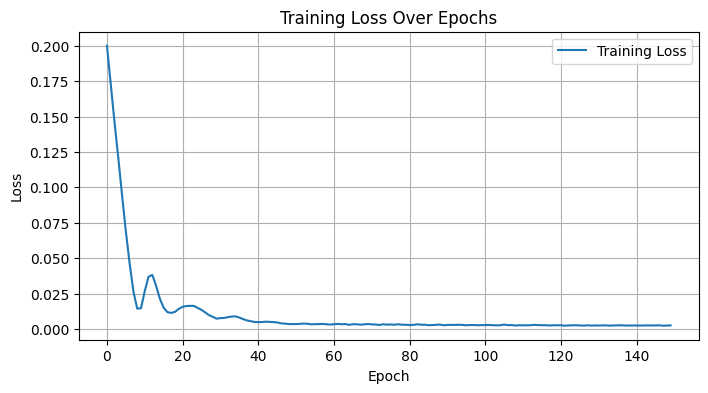

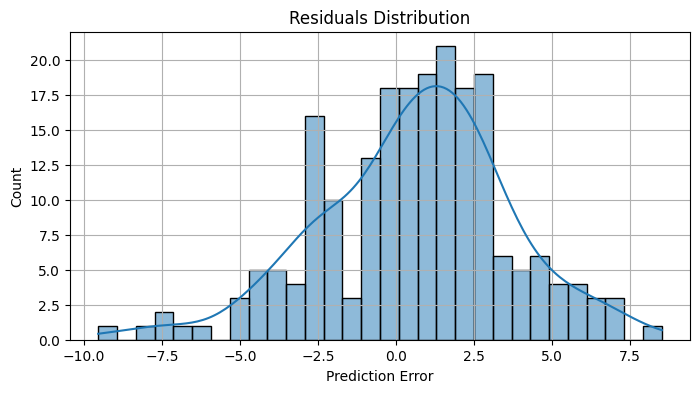

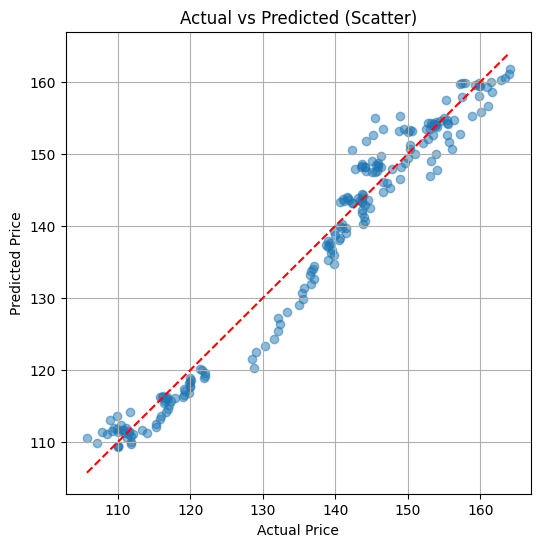


Sample Predictions:
Actual: 111.59, Predicted: 114.20
Actual: 109.83, Predicted: 113.66
Actual: 108.84, Predicted: 113.07
Actual: 110.41, Predicted: 112.32
Actual: 111.06, Predicted: 111.90
Actual: 110.88, Predicted: 111.66
Actual: 107.79, Predicted: 111.38
Actual: 108.43, Predicted: 111.07
Actual: 105.71, Predicted: 110.48
Actual: 107.11, Predicted: 109.89

Model Evaluation:
MAE  : 2.4411
RMSE : 3.0940
R² Score: 0.9642
MAPE : 1.79%
Accuracy (100 - MAPE): 98.21%
Predictions within 15% of actual values: 100.00% ✅


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
#https://paperswithcode.com/dataset/stocknet-1
#https://github.com/yumoxu/stocknet-dataset
!git clone https://github.com/yumoxu/stocknet-dataset.git
!cat stocknet-dataset/price/raw/AAPL.csv
df = pd.read_csv('/content/stocknet-dataset/price/raw/AAPL.csv')

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.drop(columns=['Adj Close'], inplace=True, errors='ignore')
df.dropna(inplace=True)

# Feature Engineering
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()
df.dropna(inplace=True)

# Normalization
features = ['Open', 'High', 'Low', 'Volume', 'MA_50', 'MA_200']
target = 'Close'
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
target_scaler = MinMaxScaler()
df[[target]] = target_scaler.fit_transform(df[[target]])

# Sequence Creation
def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features].values, df[target].values, seq_length=10)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers,
                              batch_first=True, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.bilstm.num_layers * 2, x.size(0), self.bilstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.bilstm.num_layers * 2, x.size(0), self.bilstm.hidden_size).to(x.device)
        out, _ = self.bilstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

# Hyperparameters
model = BiLSTM(input_size=len(features), hidden_size=64, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Training
train_losses = []
for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/150], Loss: {loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

y_pred = target_scaler.inverse_transform(y_pred_tensor.numpy())
y_test_actual = target_scaler.inverse_transform(y_test_tensor.numpy())

# Metrics
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
accuracy = 100 - mape  # Custom accuracy

# ✅ Additional: Percentage of predictions within 15% of actual values
within_15 = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual) <= 0.15) * 100

# 📈 Visualizations
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 📉 Training Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# 📊 Residual Plot
residuals = y_test_actual.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error")
plt.grid(True)
plt.show()

# 📌 Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Scatter)")
plt.grid(True)
plt.show()

# 🔍 Sample Predictions
print("\nSample Predictions:")
for i in range(10):
    print(f"Actual: {y_test_actual[i][0]:.2f}, Predicted: {y_pred[i][0]:.2f}")

# ✅ Final Metrics
print("\nModel Evaluation:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"Accuracy (100 - MAPE): {accuracy:.2f}%")
print(f"Predictions within 15% of actual values: {within_15:.2f}% ✅")
